In [17]:
!pip install google-generativeai

In [25]:
for model in genai.list_models():
  print(model.name)

models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-04-17
models/gemini-2.5-flash-preview-04-17-thinking
models/gemini-2.5-pro-preview-05-06
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-pr

In [18]:
from IPython import get_ipython
from IPython.display import display


import os
import json
from google.colab import userdata
import google.generativeai as genai
from collections import Counter
from datetime import datetime, timedelta
from google.colab import files

In [21]:
!pip install googlesearch-python
from googlesearch import search

In [22]:
!pip install pandas
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
# Obtenha a chave da API de Colab userdata
API_KEY = userdata.get('GOOGLE_API_KEY')

# Configure a biblioteca google.generativeai com a chave da API
genai.configure(api_key=API_KEY) # Use API_KEY here

In [24]:
# Definir o nome do arquivo para o histórico
ARQUIVO_HISTORICO = 'historico_palavras.json'

# Inicializar historico_de_palavras como uma lista vazia.
# Ele será preenchido ao carregar o arquivo.
historico_de_palavras = []


In [26]:
# Função para carregar o histórico do arquivo
def carregar_historico(nome_arquivo):
    global historico_de_palavras # Indica que vamos modificar a variável global
    historico_de_palavras = [] # Inicializa como vazio para evitar duplicatas ao recarregar
    if os.path.exists(nome_arquivo):
        try:
            with open(nome_arquivo, 'r', encoding='utf-8') as f:
                data = json.load(f)
                # Converte as strings de data de volta para objetos datetime e adiciona campo 'sentimento' se faltar
                for entry in data:
                    if 'data' in entry and isinstance(entry['data'], str):
                        try:
                            entry['data'] = datetime.fromisoformat(entry['data'])
                        except ValueError:
                             print(f"Aviso: Não foi possível converter data para datetime: {entry['data']}")
                             # Pula entradas com data inválida
                             continue # Pula para a próxima entrada
                    # Se o campo 'sentimento' não existir, classifique-o agora (chamada única por palavra ao carregar)
                    if 'sentimento' not in entry:
                        print(f"Classificando sentimento para palavra histórica: '{entry.get('palavra', 'N/A')}'")
                        entry['sentimento'] = classificar_sentimento_palavra(entry.get('palavra', '')) # Classifica se a palavra existir
                    historico_de_palavras.append(entry) # Adiciona a entrada (modificada ou original) ao histórico
                print(f"Histórico carregado com sucesso de {nome_arquivo}")
        except json.JSONDecodeError:
            print(f"Erro ao decodificar JSON de {nome_arquivo}. O arquivo pode estar corrompido.")
            historico_de_palavras = [] # Reinicia o histórico se o arquivo estiver corrompido
        except Exception as e:
            print(f"Ocorreu um erro ao carregar o histórico: {e}")
            historico_de_palavras = [] # Reinicia o histórico em caso de outros erros
    else:
        print(f"Arquivo de histórico {nome_arquivo} não encontrado. Iniciando com histórico vazio.")
        historico_de_palavras = []

# Carregar o histórico ao iniciar o script
carregar_historico(ARQUIVO_HISTORICO)


Arquivo de histórico historico_palavras.json não encontrado. Iniciando com histórico vazio.


In [27]:
# Função para salvar o histórico no arquivo
def salvar_historico(nome_arquivo):
    try:
        # Converte objetos datetime para strings antes de salvar em JSON
        data_to_save = []
        for entry in historico_de_palavras:
            saved_entry = entry.copy() # Cria uma cópia para não modificar a lista original
            if 'data' in saved_entry and isinstance(saved_entry['data'], datetime):
                saved_entry['data'] = saved_entry['data'].isoformat() # Converte datetime para string ISO 8601
            data_to_save.append(saved_entry)

        with open(nome_arquivo, 'w', encoding='utf-8') as f:
            json.dump(data_to_save, f, ensure_ascii=False, indent=4) # Salva em JSON com formatação legível
        print(f"Histórico salvo com sucesso em {nome_arquivo}")
    except Exception as e:
        print(f"Ocorreu um erro ao salvar o histórico: {e}")


# Carregar o histórico ao iniciar o script
carregar_historico(ARQUIVO_HISTORICO)

Arquivo de histórico historico_palavras.json não encontrado. Iniciando com histórico vazio.


In [28]:
# Função para converter o histórico para DataFrame
def historico_para_dataframe(historico):
    """Converte a lista de histórico para um DataFrame pandas."""
    if not historico:
        print("Histórico vazio. Não é possível criar um DataFrame.")
        return pd.DataFrame() # Retorna um DataFrame vazio se o histórico estiver vazio

    # Converte a lista de dicionários em DataFrame
    df = pd.DataFrame(historico)

    # Garante que a coluna 'data' é do tipo datetime (se ainda não for)
    # Isso é importante para o filtro de ranking, mas também útil aqui.
    # Pode ser que ao carregar do JSON a data venha como string, dependendo do ponto
    # onde esta função é chamada, por isso a conversão é segura.
    df['data'] = pd.to_datetime(df['data'], errors='coerce')

    return df

In [29]:
# Função para baixar o DataFrame como CSV
def baixar_historico_csv(dataframe, nome_arquivo="historico_palavras.csv"):
    """Salva um DataFrame em um arquivo CSV e inicia o download."""
    if dataframe.empty:
        print("DataFrame vazio. Nada para baixar.")
        return

    try:
        dataframe.to_csv(nome_arquivo, index=False, encoding='utf-8')
        print(f"Preparando download de '{nome_arquivo}'...")
        files.download(nome_arquivo)
        print("Download iniciado.")
    except Exception as e:
        print(f"Erro ao baixar o arquivo CSV: {e}")

In [30]:
# ... código anterior ...

def sugerir_momentos_felizes(resumo_do_dia):
    """
    Sugere atividades para melhorar o humor com base no resumo do dia
    e resultados de busca no Google.
    """
    google_query = resumo_do_dia + " como lidar com" # Exemplo de consulta
    google_results = []
    try:
        for result in search(google_query, num_results=3): # Busca os 3 primeiros resultados
            google_results.append(result)
    except Exception as e:
        print(f"Erro na busca do Google: {e}")
        # Continua mesmo se a busca falhar, mas sem contexto do Google
        google_results = [] # Garante que google_results é uma lista vazia em caso de erro

    # Formata os resultados da busca para incluir no prompt
    if google_results:
        # Modificação: Remove a descrição dos links e foca apenas nos links em si ou em um resumo genérico
        google_context = "Considere as seguintes informações relevantes:\n"
        for i, result in enumerate(google_results):
            # Você pode escolher como formatar. Apenas o link ou um resumo genérico.
            google_context += f"- {result}\n" # Apenas o link
            # Ou, se preferir uma descrição mais genérica:
            # google_context += f"- Informação útil relacionada ao tema: {result}\n" # Usar o link como exemplo de informação

    else:
        google_context = "Nenhuma informação relevante encontrada em fontes externas.\n"


    # Prepara o prompt para o Gemini, incluindo o contexto do Google Search
    prompt_text = f"""
    Considerando o seguinte resumo do meu dia: "{resumo_do_dia}".

    {google_context} # Inclui as informações possivelmente relevantes

    Com base no resumo do dia e nas informações possivelmente úteis fornecidas,
    sugira 3 a 5 atividades simples, práticas e rápidas que eu poderia fazer agora para **ajudar a melhorar o humor ou trazer um momento de relaxamento/conforto**.
    As sugestões devem ser apresentadas como uma lista numerada.
    Priorize sugestões que sejam relevantes para o resumo do dia, usando as informações úteis como inspiração, **mas evite mencionar explicitamente "links" ou fazer suposições detalhadas sobre o conteúdo deles**.
    **Enfatize que são apenas opções para explorar e não metas a serem alcançadas.**
    """

    model = genai.GenerativeModel('gemini-1.5-flash')
    try:
        response = model.generate_content(prompt_text)
        return response.text
    except Exception as e:
        print(f"Erro ao gerar conteúdo com Gemini: {e}")
        return "Desculpe, não foi possível gerar sugestões de momentos de bem-estar neste momento. Tente novamente mais tarde."

# ... o restante do código ...

In [31]:
# Função para registrar as palavras e classificar o sentimento no momento do registro
def registrar_palavras(palavras):
    data_registro = datetime.now()
    for palavra in palavras:
        # Classifica o sentimento no momento do registro para evitar chamadas futuras repetidas
        sentimento_classificado = classificar_sentimento_palavra(palavra)
        historico_de_palavras.append({
            'palavra': palavra,
            'data': data_registro,
            'sentimento': sentimento_classificado # Armazenar o sentimento classificado
        })

In [32]:
def analisar_sentimento(palavras):
    """
    Analisa o sentimento geral das palavras, fornece uma pontuação
    e identifica categorias de sentimento mais específicas.
    """
    prompt_text = f"""
    Analise o sentimento das seguintes palavras, que resumem o dia de uma pessoa: "{', '.join(palavras)}".
    Forneça:
    1. Uma pontuação de sentimento geral em uma escala de -1 (muito negativo) a 1 (muito positivo).
    2. O sentimento predominante (Positivo, Negativo ou Neutro).
    3. Categórias de sentimento mais específicas que descrevam as palavras (ex: "grato", "cansado", "animado", "frustrado", "calmo", etc.). Liste até 3 categorias se aplicável.
    4. Uma breve explicação do porquê esses sentimentos e a pontuação foram identificados com base nas palavras fornecidas.

    Formate a resposta da seguinte maneira:
    Pontuação: [pontuação numérica]
    Predominante: [Sentimento Predominante]
    Categorias: [Categoria 1], [Categoria 2], ... (se houver)
    Análise: [Breve explicação]

    Reconheça que todos os sentimentos são válidos e parte da experiência humana.
    Adicionalmente, ofereça uma breve sugestão ou reflexão sobre como lidar com o sentimento identificado de forma construtiva (seja ele positivo ou negativo).
    """

    model = genai.GenerativeModel('gemini-1.5-flash')
    try:
        response = model.generate_content(prompt_text)
        return response.text
    except Exception as e:
        print(f"Erro ao gerar conteúdo com Gemini: {e}")
        return "Desculpe, não foi possível realizar a análise de sentimento neste momento."

In [33]:
# Função para classificar o sentimento de uma única palavra
def classificar_sentimento_palavra(palavra):
    """
    Classifica o sentimento de uma única palavra como positivo, negativo ou neutro
    usando o Gemini. Retorna a classificação (string).
    """
    prompt_text = f"""
    Classifique a seguinte palavra em uma das categorias de sentimento: Positivo, Negativo ou Neutro.
    Palavra: "{palavra}"
    Responda apenas com a palavra da categoria de sentimento (Positivo, Negativo ou Neutro), sem explicações adicionais.
    """
    model = genai.GenerativeModel('gemini-1.5-flash')
    try:
        response = model.generate_content(prompt_text)
        # Limpa a resposta para obter apenas a categoria (remove espaços em branco, etc.)
        sentimento = response.text.strip()
        # Valida se a resposta é uma das categorias esperadas
        if sentimento in ['Positivo', 'Negativo', 'Neutro']:
            return sentimento
        else:
            # Se a resposta não for clara, consideramos neutro ou lidamos de outra forma
            print(f"Aviso: Classificação inesperada para '{palavra}': '{sentimento}'. Considerado Neutro.")
            return 'Neutro'
    except Exception as e:
        print(f"Erro ao classificar sentimento para '{palavra}': {e}. Considerado Neutro.")
        return 'Neutro'

In [34]:
# Função para obter dados de frequência de sentimento por período
def obter_frequencia_sentimento(historico, periodo=None):
    """
    Calcula a frequência de palavras por sentimento (Positivo, Negativo, Neutro)
    em um determinado período, using the sentiment already classified in the history.
    """
    df = historico_para_dataframe(historico)

    if df.empty:
        print("Histórico vazio. Não é possível calcular a frequência de sentimentos.")
        return {}

    # Filtra por período, se especificado
    df_filtrado = df # Start with the full dataframe

    if periodo == 'semanal':
        data_limite = datetime.now() - timedelta(days=7)
        df_filtrado = df_filtrado[df_filtrado['data'] >= data_limite]
    elif periodo == 'mensal':
        data_limite = datetime.now() - timedelta(days=30) # Aproximadamente um mês
        df_filtrado = df_filtrado[df_filtrado['data'] >= data_limite]
    # If periodo is None or 'total', df_filtrado remains the full dataframe

    if df_filtrado.empty:
        print(f"Nenhuma palavra encontrada no período {periodo}.")
        return {}

    # Ensure the 'sentimento' column exists and count the occurrences
    if 'sentimento' in df_filtrado.columns:
        # Use value_counts on the 'sentimento' column
        contagem_sentimento = df_filtrado['sentimento'].value_counts().to_dict()
        return contagem_sentimento
    else:
        print("Aviso: Coluna 'sentimento' não encontrada no DataFrame. Não é possível calcular a frequência de sentimentos.")
        return {}

In [35]:
# Função para obter o ranking das palavras mais frequentes por período
def obter_ranking_palavras(historico, periodo=None, top_n=10):
    """
    Calcula o ranking das palavras mais frequentes em um determinado período.
    """
    df = historico_para_dataframe(historico)

    if df.empty:
        return []

    # Filtra por período, se especificado
    if periodo == 'semanal':
        data_limite = datetime.now() - timedelta(days=7)
        df_filtrado = df[df['data'] >= data_limite]
    elif periodo == 'mensal':
        data_limite = datetime.now() - timedelta(days=30) # Aproximadamente um mês
        df_filtrado = df[df['data'] >= data_limite]
    else: # Período total
        df_filtrado = df

    if df_filtrado.empty:
        print(f"Nenhuma palavra encontrada no período {periodo}.")
        return []

    # Usa Counter para contar a frequência das palavras
    # Achata a lista de listas (se palavras_chave fosse uma lista de listas) ou apenas conta
    # No seu caso, 'palavra' é uma string em cada entrada do histórico
    todas_palavras = df_filtrado['palavra'].tolist()
    contagem_palavras = Counter(todas_palavras)

    # Obtém o ranking das palavras mais comuns
    ranking = contagem_palavras.most_common(top_n)

    return ranking

In [36]:
def gerar_grafico_sentimento(dados_frequencia, periodo_label="total"):
    """
    Gera um gráfico de barras da frequência de sentimentos com design moderno.
    Usa cores semafóricas (Verde/Positivo, Vermelho/Negativo, Azul/Neutro).
    """
    if not dados_frequencia:
        display(Markdown("Não há dados para gerar o gráfico."))
        return

    # Definir as cores para cada sentimento
    cores_sentimento = {
        'Positivo': '#34a853',  # Verde do Google
        'Negativo': '#ea4335',  # Vermelho do Google
        'Neutro': '#4285f4'     # Azul do Google
    }

    # Ordenar os sentimentos para garantir a ordem das cores e barras
    ordem_sentimentos = ['Negativo', 'Neutro', 'Positivo']
    sentimentos_ordenados = [s for s in ordem_sentimentos if s in dados_frequencia]
    frequencias_ordenadas = [dados_frequencia.get(s, 0) for s in sentimentos_ordenados]
    cores_plotagem = [cores_sentimento.get(s, '#fbbc05') for s in sentimentos_ordenados] # Amarelo do Google como fallback

    # Criar um DataFrame temporário para facilitar o uso com hue
    df_grafico = pd.DataFrame({
        'Sentimento': sentimentos_ordenados,
        'Frequência': frequencias_ordenadas
    })

    # Mapear os sentimentos para as cores para usar com hue
    # Garantimos que a ordem no mapeamento seja a mesma para a paleta
    palette_mapping = {s: cores_sentimento.get(s, '#fbbc05') for s in sentimentos_ordenados}


    # Usar um estilo de seaborn mais limpo e moderno
    sns.set_theme(style="whitegrid") # ou "white", "ticks" dependendo da preferência

    plt.figure(figsize=(10, 6)) # Ajuste o tamanho da figura
    # Modificado: Passando 'Sentimento' para hue e usando a paleta mapeada, desativando a legenda
    ax = sns.barplot(x='Sentimento', y='Frequência', hue='Sentimento', data=df_grafico,
                     palette=palette_mapping, alpha=0.9, legend=False)

    # Remover bordas e alguns eixos para um visual mais limpo
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # Manter o eixo inferior (bottom) para os labels de sentimento
    ax.spines['bottom'].set_linewidth(0.5) # Linha inferior mais fina

    ax.set_facecolor('white') # Fundo branco para um visual limpo

    # Adicionar os valores de frequência no topo de cada barra
    # Percorremos os patches do eixo para anotar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', # Garante que o valor seja um inteiro
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 8), textcoords='offset points',
                    fontsize=10, color='black') # Ajusta fonte e cor do texto

    # Melhorar os rótulos e título
    plt.title(f'Frequência de Sentimentos ({periodo_label.capitalize()})', fontsize=16, weight='bold', color='#3c4043') # Cor do texto do Google
    plt.xlabel('Sentimento', fontsize=12, color='#3c4043')
    plt.ylabel('Frequência', fontsize=12, color='#3c4043')
    plt.yticks([]) # Remover ticks do eixo Y, já que os valores estão nas barras

    # Ajustar os ticks do eixo X para um visual mais limpo
    ax.tick_params(axis='x', length=0, labelsize=11, colors='#3c4043') # Remove ticks e ajusta labels

    # Layout justo para evitar cortes
    plt.tight_layout()

    plt.show()

# Diário de Sentimentos Interativo

## Olá! Eu sou AnandaBot!

Meu nome, Ananda (आनन्द), vem do Sânscrito e significa **'bem-aventurança'**, **'alegria suprema'**.

Ananda também foi um discípulo de Buda, conhecido por sua compaixão e memória.

Estou aqui para te ajudar a refletir sobre seus sentimentos e encontrar momentos de bem-estar.

Como você gostaria de ser chamado(a)? Ju


Que nome bonito, **Ju**!

Para te conhecer um pouco melhor, Ju, qual é a sua data de nascimento (formato DD/MM/AAAA)? 03/09/2005


Que legal! Então você tem **19** anos!


Pronto para começar nosso diário de sentimentos, Ju?

# Diário de Sentimentos Interativo


---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 1


---

Como foi seu dia hoje (em um breve resumo)? Acordei e PÁ! Dei com o dedinho do pé na quina da porta. Mano do céu, pensa numa dor! Já comecei o dia com o pé esquerdo... literalmente! Achei que ia ser só ladeira abaixo.  Mas aí, beleza, fui pra cima nos estudos da Alura. Mergulhei de cabeça nos cursos, e que parada irada! Cada módulo era uma descoberta nova, minha mente tá fervilhando com tanta informação. Esqueci da dor, esqueci de tudo! O foco foi total em aprender e absorver o máximo. De um começo meio torto pra um dia superprodutivo, a Alura mandou bem demais. Agora é descansar porque amanhã tem mais, e o dedinho já tá avisado pra ficar esperto! Valeu cada segundo, sério mesmo!


### Análise do seu dia:

Pontuação: 0.7
Predominante: Positivo
Categorias: Animado, Satisfeito, Aliviado
Análise: O texto inicia com uma experiência negativa (a dor no dedo do pé), expressa com linguagem informal e exclamativa que indica surpresa e desconforto.  A frase "Já comecei o dia com o pé esquerdo... literalmente!" reforça esse sentimento inicial negativo.  No entanto, a narrativa rapidamente muda de foco para a experiência positiva de estudar na Alura.  As palavras "irada", "descoberta nova", "mente fervilhando", "superprodutivo" e "vale cada segundo" demonstram entusiasmo, satisfação e realização.  O sentimento negativo inicial é superado e eclipsado pela alegria e produtividade experimentadas ao longo do dia. A pontuação de 0.7 reflete esse balanço, com o positivo preponderando significativamente sobre o negativo inicial.

Sugestão/Reflexão:  Embora o dia tenha começado com um contratempo, a capacidade de superar a frustração inicial e se concentrar em algo gratificante (os estudos) é uma habilidade valiosa.  Essa experiência reforça a importância da resiliência e da capacidade de mudar de foco quando enfrentamos adversidades.  Aproveitar os momentos positivos e aprender com os negativos é uma forma construtiva de lidar com os altos e baixos da vida.  Manter a atenção nos objetivos e celebrar os sucessos diários, mesmo os pequenos, contribui para a construção de uma perspectiva positiva e um bem-estar geral.


### Sugestões para um momento de bem-estar:

Aqui estão algumas atividades simples e rápidas para ajudar a melhorar o humor ou trazer um momento de relaxamento após um dia produtivo, inspiradas pelo seu resumo:

1. **Alongamento leve:**  Após um dia focado em estudos, seu corpo pode estar tenso.  Alongar suavemente os músculos, principalmente os das pernas e pés (em memória do dedinho!), pode aliviar a tensão e promover relaxamento.  Lembre-se: o objetivo é conforto, não uma sessão intensa de exercícios.

2. **Momento de leitura leve:**  Busque algo prazeroso e de fácil digestão para ler, algo que não exija esforço mental significativo.  Um conto curto, um capítulo de um livro leve, ou até mesmo uma revista com imagens bonitas podem proporcionar um descanso mental e uma sensação de calma.

3. **Música relaxante:**  Coloque uma música calma e relaxante para tocar.  Escolha um gênero que você goste e que te traga paz.  Fecha os olhos e deixe a melodia te levar para um estado de tranquilidade.  Experimente diferentes gêneros musicais até encontrar algo que te agrade.

4. **Bebida quente e reconfortante:** Prepare um chá de ervas ou uma bebida quente que você goste. O ato de preparar e saborear a bebida lentamente pode ser uma pequena forma de autocuidado e um momento de pausa para refletir sobre o dia.

5. **Escreva três coisas boas do seu dia:**  Apesar do começo conturbado, seu dia foi produtivo e cheio de aprendizado. Anote três coisas positivas que aconteceram, focando no sucesso nos seus estudos e na superação do início desafiador.  Isso reforça a sensação de realização e contribui para um estado emocional positivo.


Lembre-se: essas são apenas *opções* para explorar e não metas a serem alcançadas.  Escolha a atividade que mais te atrai no momento e aproveite o momento de descanso!



---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 2


---

Digite 5 palavras-chave que resumem seu dia (separe por vírgula): dor, aprendizagem, ansiedade, avanços, novidades
Histórico salvo com sucesso em historico_palavras.json


<p style='color:green;'>Palavras-chave registradas no histórico.</p>

### Análise baseada nas 5 palavras-chave:

Pontuação: 0
Predominante: Neutro
Categorias:  Ansiedade, Progresso, Dor
Análise: O conjunto de palavras apresenta uma mistura de sentimentos positivos e negativos. "Dor" e "ansiedade" indicam experiências negativas, enquanto "aprendizagem", "avanços" e "novidades" sugerem aspectos positivos e de crescimento.  A "dor" pode ser física ou emocional, enquanto a ansiedade indica incerteza. Os "avanços" e "novidades" demonstram progresso e potencial, mas sem necessariamente anular a experiência negativa. A ausência de sentimentos fortemente positivos ou negativos resulta em uma pontuação neutra.

Sugestão/Reflexão: A presença simultânea de dor e ansiedade com avanços e novidades sugere um dia de transformação e crescimento, apesar do desconforto.  Para lidar com isso de forma construtiva, é importante reconhecer e validar as emoções negativas (dor e ansiedade) sem se deixar paralisar por elas.  Focalizar nos "avanços" e "novidades" como conquistas, aprendendo com a experiência e  buscando formas saudáveis de gerenciar a ansiedade (como exercícios físicos, meditação ou conversa com alguém próximo), pode transformar um dia neutro em um dia de aprendizado e crescimento pessoal.



---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 3


---

## Histórico de Palavras

| Data e Hora       | Palavra          | Sentimento        |
|-------------------|------------------|-------------------|
| 18/05/2025 13:10 | Dor              | Negativo          |
| 18/05/2025 13:10 | Aprendizagem     | Positivo          |
| 18/05/2025 13:10 | Ansiedade        | Negativo          |
| 18/05/2025 13:10 | Avanços          | Positivo          |
| 18/05/2025 13:10 | Novidades        | Positivo          |



---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 4


---

Preparando download de 'historico_palavras.csv'...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download iniciado.



---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 5


---

## Ranking das Palavras Mais Frequentes

Escolha o período (semanal, mensal, total): total
Quantas palavras deseja ver no ranking? (Digite um número): 5


### Ranking (Total - Top 5):
1. **Dor**: 1 ocorrência(s)
2. **Aprendizagem**: 1 ocorrência(s)
3. **Ansiedade**: 1 ocorrência(s)
4. **Avanços**: 1 ocorrência(s)
5. **Novidades**: 1 ocorrência(s)



---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 6


---

## Gráfico de Frequência de Sentimentos

Escolha o período (semanal, mensal, total): total


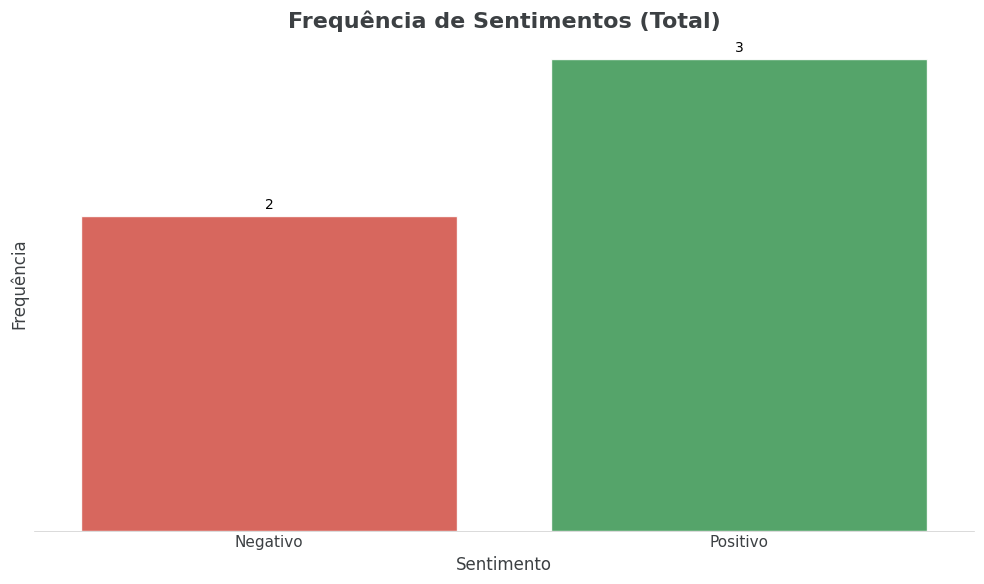


---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 2


---

Digite 5 palavras-chave que resumem seu dia (separe por vírgula): alegria, amigos, jogos, saudade, cansaço
Histórico salvo com sucesso em historico_palavras.json


<p style='color:green;'>Palavras-chave registradas no histórico.</p>

### Análise baseada nas 5 palavras-chave:

Pontuação: 0.5
Predominante: Positivo
Categorias: Alegria, Cansaço, Saudade
Análise: A lista contém uma mistura de sentimentos positivos e negativos. "Alegria", "amigos" e "jogos" contribuem para um sentimento positivo e animado.  "Cansaço" introduz um elemento negativo, enquanto "saudade" é um sentimento mais complexo, podendo ser interpretado como levemente negativo ou neutro dependendo do contexto, representando uma mistura de nostalgia e talvez uma leve tristeza.  O peso dos sentimentos positivos é maior, levando a uma pontuação positiva, mas o cansaço reduz a pontuação para 0,5, indicando uma experiência equilibrada entre emoções positivas e negativas.

Sugestão/Reflexão: O dia parece ter sido bastante agitado e cheio de momentos bons e ruins.  Para lidar de forma construtiva com o cansaço, seria importante priorizar o descanso e a recuperação.  Uma noite de sono tranquila e um tempo para relaxar podem ajudar a recarregar as energias para o próximo dia. A saudade pode ser trabalhada conectando-se com as pessoas ou memórias que a causaram,  se possível.  Aproveitar os momentos de alegria e a companhia dos amigos é uma forma de cultivar a positividade.



---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 3


---

## Histórico de Palavras

| Data e Hora       | Palavra          | Sentimento        |
|-------------------|------------------|-------------------|
| 18/05/2025 13:10 | Dor              | Negativo          |
| 18/05/2025 13:10 | Aprendizagem     | Positivo          |
| 18/05/2025 13:10 | Ansiedade        | Negativo          |
| 18/05/2025 13:10 | Avanços          | Positivo          |
| 18/05/2025 13:10 | Novidades        | Positivo          |
| 18/05/2025 13:12 | Alegria          | Positivo          |
| 18/05/2025 13:12 | Amigos           | Positivo          |
| 18/05/2025 13:12 | Jogos            | Neutro            |
| 18/05/2025 13:12 | Saudade          | Negativo          |
| 18/05/2025 13:12 | Cansaço          | Negativo          |



---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


Digite o número da sua escolha: 6


---

## Gráfico de Frequência de Sentimentos

Escolha o período (semanal, mensal, total): total


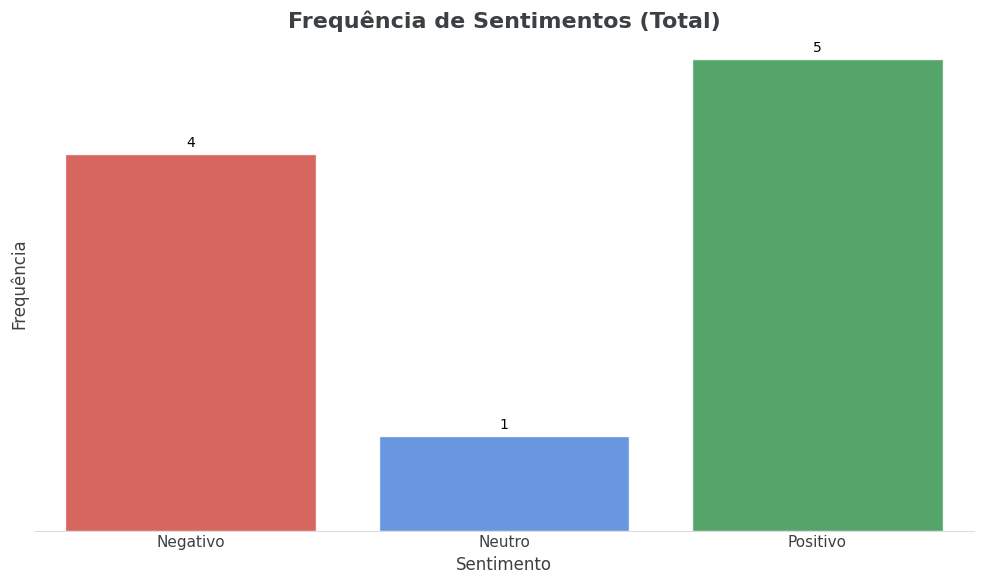


---
## Olá, Ju! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**


In [ ]:
from IPython.display import display, Markdown
display(Markdown("# Diário de Sentimentos Interativo"))

# --- Início da Introdução do AnandaBot ---
display(Markdown("## Olá! Eu sou AnandaBot!"))
display(Markdown("Meu nome, Ananda (आनन्द), vem do Sânscrito e significa **'bem-aventurança'**, **'alegria suprema'**."))
display(Markdown("Ananda também foi um discípulo de Buda, conhecido por sua compaixão e memória."))
display(Markdown("Estou aqui para te ajudar a refletir sobre seus sentimentos e encontrar momentos de bem-estar."))

# Coletar nome do usuário
nome_usuario = input("Como você gostaria de ser chamado(a)? ")
if nome_usuario.strip():
    display(Markdown(f"Que nome bonito, **{nome_usuario.capitalize()}**!"))
else:
    nome_usuario = "pessoa querida" # Nome padrão se o usuário não digitar nada
    display(Markdown(f"Tudo bem, vou te chamar de **{nome_usuario}**."))

# Coletar data de nascimento para calcular a idade
while True:
    data_nascimento_str = input(f"Para te conhecer um pouco melhor, {nome_usuario.capitalize()}, qual é a sua data de nascimento (formato DD/MM/AAAA)? ")
    try:
        # Tenta converter a string para um objeto datetime
        data_nascimento = datetime.strptime(data_nascimento_str, '%d/%m/%Y')

        # Calcula a idade
        hoje = datetime.now()
        idade = hoje.year - data_nascimento.year - ((hoje.month, hoje.day) < (data_nascimento.month, data_nascimento.day))

        display(Markdown(f"Que legal! Então você tem **{idade}** anos!"))
        break # Sai do loop se a data for válida
    except ValueError:
        display(Markdown("<p style='color:red;'>Formato de data inválido. Por favor, use o formato DD/MM/AAAA (ex: 01/01/2000).</p>"))

display(Markdown(f"\nPronto para começar nosso diário de sentimentos, {nome_usuario.capitalize()}?"))

# --- Fim da Introdução do AnandaBot ---

display(Markdown("# Diário de Sentimentos Interativo"))

while True:
    # Modifique a string do menu_markdown para incluir o nome do usuário
    menu_markdown = f"""
---
## Olá, {nome_usuario.capitalize()}! O que você gostaria de fazer hoje?

1.  **Resumir meu dia e obter sugestões de bem-estar** (resumo geral, sem registro no histórico)
2.  **Registrar 5 palavras-chave do meu dia e analisar sentimento** (para histórico e análise de frequência)
3.  **Ver histórico de palavras**
4.  **Baixar histórico como CSV**
5.  **Ver ranking das palavras mais frequentes**
6.  **Ver frequência de sentimentos (gráfico)**
7.  **Limpar histórico de palavras**
8.  **Sair**
"""
    display(Markdown(menu_markdown))

    escolha = input("Digite o número da sua escolha: ")

    if escolha == '1':
        display(Markdown("---"))
        resumo_dia_geral = input("Como foi seu dia hoje (em um breve resumo)? ")

        if resumo_dia_geral.strip():
            # Usa o resumo geral para análise de sentimento e sugestões,
            # mas ESTE RESUMO NÃO VAI PARA O HISTÓRICO DE PALAVRAS.
            analise_md = analisar_sentimento([resumo_dia_geral]) # Analisa o resumo como uma "palavra" ou frase
            display(Markdown("### Análise do seu dia:"))
            display(Markdown(analise_md))

            sugestoes_md = sugerir_momentos_felizes(resumo_dia_geral)
            display(Markdown("### Sugestões para um momento de bem-estar:"))
            display(Markdown(sugestoes_md))
        else:
            display(Markdown("<p style='color:orange;'>Por favor, digite um breve resumo do seu dia.</p>"))

    elif escolha == '2':
        display(Markdown("---"))
        palavras_chave_input = input("Digite 5 palavras-chave que resumem seu dia (separe por vírgula): ")
        # Processa a entrada em palavras, removendo espaços e convertendo para minúsculas
        palavras_chave = [p.strip().lower() for p in palavras_chave_input.split(',') if p.strip()]

        if len(palavras_chave) == 5:
            # Registra AS 5 PALAVRAS-CHAVE no histórico para frequência e ranking
            registrar_palavras(palavras_chave)
            salvar_historico(ARQUIVO_HISTORICO)
            display(Markdown("<p style='color:green;'>Palavras-chave registradas no histórico.</p>"))

            # Analisa o sentimento APENAS das 5 palavras-chave
            analise_palavras_md = analisar_sentimento(palavras_chave)
            display(Markdown("### Análise baseada nas 5 palavras-chave:"))
            display(Markdown(analise_palavras_md))

        else:
            display(Markdown("<p style='color:orange;'>Por favor, digite exatamente 5 palavras-chave separadas por vírgula.</p>"))

    elif escolha == '3':
        display(Markdown("---"))
        if historico_de_palavras:
            output_md = "## Histórico de Palavras\n\n"
            output_md += "| Data e Hora       | Palavra          | Sentimento        |\n"
            output_md += "|-------------------|------------------|-------------------|\n"
            for entrada in historico_de_palavras:
                data_formatada = entrada['data'].strftime('%d/%m/%Y %H:%M') if isinstance(entrada['data'], datetime) else str(entrada['data'])
                palavra = entrada['palavra']
                sentimento = entrada.get('sentimento', 'Não classificado')
                output_md += f"| {data_formatada} | {palavra.capitalize():<16} | {sentimento.capitalize():<17} |\n"
            display(Markdown(output_md))
        else:
            display(Markdown("Seu histórico de palavras está vazio."))

    elif escolha == '4':
        display(Markdown("---"))
        df_historico = historico_para_dataframe(historico_de_palavras)
        if not df_historico.empty:
            baixar_historico_csv(df_historico)
        else:
            display(Markdown("<p style='color:orange;'>Não há dados no histórico para baixar.</p>"))

    elif escolha == '5':
        display(Markdown("---"))
        display(Markdown("## Ranking das Palavras Mais Frequentes"))
        periodo_ranking = input("Escolha o período (semanal, mensal, total): ").lower()
        try:
            top_n_ranking_str = input("Quantas palavras deseja ver no ranking? (Digite um número): ")
            top_n_ranking = int(top_n_ranking_str)
            if top_n_ranking <= 0:
                display(Markdown("<p style='color:red;'>Por favor, insira um número positivo para o ranking.</p>"))
                continue

            # O ranking já usa as palavras registradas no histórico, que agora virão da opção 2
            ranking = obter_ranking_palavras(historico_de_palavras, periodo=periodo_ranking, top_n=top_n_ranking)

            if ranking:
                output_md = f"### Ranking ({periodo_ranking.capitalize()} - Top {top_n_ranking}):\n"
                for i, (palavra, frequencia) in enumerate(ranking):
                    output_md += f"{i+1}. **{palavra.capitalize()}**: {frequencia} ocorrência(s)\n"
                display(Markdown(output_md))
            else:
                display(Markdown(f"Não há palavras suficientes para gerar um ranking no período '{periodo_ranking}' ou o histórico está vazio."))
        except ValueError:
            display(Markdown("<p style='color:red;'>Entrada inválida para o número de palavras. Por favor, digite um número.</p>"))


    elif escolha == '6':
        display(Markdown("---"))
        display(Markdown("## Gráfico de Frequência de Sentimentos"))
        periodo_sentimento = input("Escolha o período (semanal, mensal, total): ").lower()

        # A frequência já usa as palavras registradas no histórico, que agora virão da opção 2
        dados_frequencia = obter_frequencia_sentimento(historico_de_palavras, periodo=periodo_sentimento)

        if dados_frequencia:
            gerar_grafico_sentimento(dados_frequencia, periodo_sentimento)
        else:
            display(Markdown(f"<p style='color:orange;'>Não há dados de sentimento para gerar o gráfico no período '{periodo_sentimento}'.</p>"))

    elif escolha == '7':
        display(Markdown("---"))
        confirmacao = input("Tem certeza que deseja limpar todo o histórico de palavras? (sim/não): ").lower()
        if confirmacao == 'sim':
            historico_de_palavras = [] # Limpa a lista na memória
            salvar_historico(ARQUIVO_HISTORICO) # Salva o arquivo JSON vazio
            display(Markdown("<p style='color:green;'>Histórico de palavras limpo com sucesso.</p>"))
        else:
            display(Markdown("<p style='color:blue;'>Limpeza do histórico cancelada.</p>"))

    elif escolha == '8':
        display(Markdown("---"))
        display(Markdown("### Obrigado por usar o Diário de Sentimentos! Até mais. 👋"))
        break # Sai do loop

    else:
        display(Markdown("<p style='color:red;'>**Escolha inválida.** Por favor, digite um número de 1 a 8.</p>"))




